# Hindmarsh-Roseモデル

\begin{equation}
\left\{
    \begin{aligned}
        \dot{V} &= n - a V^3 + b V^2 - h + I,\\
        \dot{n} &= c - d V^2 -n.
    \end{aligned}
\right.    
\end{equation}
リミットサイクルの追跡を有限差分法で行う

In [1]:
import numpy as np
import pathfollowing as pf
from scipy.integrate import ode, solve_ivp
from scipy.linalg import solve, eigvals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set('poster', 'whitegrid', 'dark', rc={"lines.linewidth": 2, 'grid.linestyle': '-'})

In [2]:
def f(x, a):
    return np.array([x[1] - x[0]**3 + 3 * x[0]**2 - a[0] + 2, 1 - 5*x[0]**2 - x[1]])

def fx(x, a):
    return np.array([[-3*x[0]**2+6*x[0], 1.0],[-10*x[0], -1.0]])

def fa(x, a):
    return np.array([-1.0, 0.0])

In [3]:
def HR(t, x, a,b,c,d,I,h):
    return np.array([x[1] - a*x[0]**3 + b * x[0]**2 - h + I, c - d*x[0]**2 - x[1]])

## 平衡点の追跡

In [4]:
h = 1.0
x0 = np.array([1.0, -4.52182801])
r = ode(HR).set_integrator('dop853')
r.set_initial_value(x0, 0.0).set_f_params(1.0, 3.0, 1.0, 5.0, 2.0, 5.0)
sol = []
while r.successful and r.t < 100:
    sol.append(r.integrate(r.t+h))
print(sol[-1])

[ -2.3593041  -26.83157883]


In [5]:
x=np.array([-2.35930409, -26.83157885])
a=np.array([5.0])
bdeq,bpeq,lpeq,hbeq=pf.pathfollow(x, a, f, fx, fa,nmax=175, h=0.1, epsr=1.0e-10, epsb=1.0e-10, problem='equilibria', quiet=True)
bdeq2,bpeq2,lpeq2,hbeq2=pf.pathfollow(x, a, f, fx, fa,nmax=550, h=-0.1, epsr=1.0e-10, epsb=1.0e-10, amin=-10.0,problem='equilibria',quiet=True)

# parameter arrived at boundary


In [6]:
print(hbeq, hbeq2)
print(bdeq2[-1]['a'])
for i in hbeq2:
    print(bdeq2[i])

[] [290, 498]
[-10.01899244]
{'TY': 'H', 'x': array([0.18350342, 0.83163248]), 'a': array([2.92647379]), 'v': array([-0.40001257,  0.83188401,  0.3846543 ]), 'udim': 0, 'vr': array([-0.52073336,  0.78171337]), 'vi': array([-0.28559796, -0.19024926]), 'omg': 0.9138020522644607}
{'TY': 'H', 'x': array([  1.81649658, -15.49829914]), 'a': array([-9.59314045]), 'v': array([-0.03995925,  0.72616588,  0.68635733]), 'udim': 2, 'vr': array([-0.05652179,  0.97347641]), 'vi': array([-0.22132291, -0.01285041]), 'omg': 4.143062370913243}


In [7]:
bdeq_r = np.array([bdeq[m]['a'][0] for m in range(len(bdeq))])
bdeq_V = np.array([bdeq[m]['x'][0] for m in range(len(bdeq))])
bdeq2_r = np.array([bdeq2[m]['a'][0] for m in range(len(bdeq2))])
bdeq2_V = np.array([bdeq2[m]['x'][0] for m in range(len(bdeq2))])

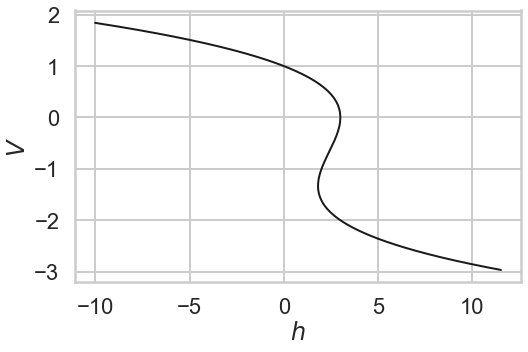

In [8]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
# ax.set_xlim(0,3)
# ax.set_ylim(-3, 3)
ax.set_xlabel("$h$")
ax.set_ylabel("$V$")
ax.plot(bdeq_r, bdeq_V, '-k')
ax.plot(bdeq2_r, bdeq2_V, '-k')
# plt.savefig("bd_lrz.pdf", bbox_inches='tight')

## 有限差分による極限周期軌道追跡

In [9]:
Npts = 128
def func(x, a):
    T = x[-1]
    h = 1.0 / Npts
    n = (len(x) - 1) // Npts
    ss = np.sin([2*np.pi*j*h for j in range(Npts)])
    y = np.zeros(len(x))
    # tau_0 = 0
    y[:n] = (x[n:2*n] - x[(Npts-1)*n:Npts*n])*0.5/h - T * f(x[:n], a)
    # tau_1 ... tau_{N-2}
    for j in range(1, Npts-1):
        y[j*n:(j+1)*n] = (x[(j+1)*n:(j+2)*n] - x[(j-1)*n:j*n])*0.5/h - T * f(x[j*n:(j+1)*n], a)
    # tau_{N-1} = (N-1) * h
    y[(Npts-1)*n:Npts*n] = (x[:n] - x[(Npts-2)*n:(Npts-1)*n])*0.5/h - T * f(x[(Npts-1)*n:Npts*n], a)
    # Phase condition
    y[-1] = x[:-1:n] @ ss
    return y

def dfdx(x, a):
    T = x[-1]
    n = (len(x)-1) // Npts
    h = 1.0 / Npts
    A = np.zeros((len(x), len(x)))
    I = np.identity(n)
    # j = 0
    A[:n, n:2*n] += I * 0.5 / h
    A[:n, (Npts-1)*n:Npts*n] -= I * 0.5 / h
    A[:n,:n] += -T * fx(x[:n], a)
    A[:n,-1] += -f(x[:n], a)
    # j = 1 ... N-2
    for j in range(1, Npts-1):
        A[j*n:(j+1)*n, (j+1)*n:(j+2)*n] += I * 0.5 / h
        A[j*n:(j+1)*n, (j-1)*n:j*n] -= I * 0.5 / h
        A[j*n:(j+1)*n, j*n:(j+1)*n] += -T * fx(x[j*n:(j+1)*n], a)
        A[j*n:(j+1)*n, -1] = -f(x[j*n:(j+1)*n], a)
    # j = N - 1
    A[(Npts-1)*n:Npts*n, :n] += I * 0.5 / h
    A[(Npts-1)*n:Npts*n, (Npts-2)*n:(Npts-1)*n] -= I * 0.5 / h
    A[(Npts-1)*n:Npts*n, (Npts-1)*n:Npts*n] += -T*fx(x[(Npts-1)*n:Npts*n], a)
    A[(Npts-1)*n:Npts*n, -1] += -f(x[(Npts-1)*n:Npts*n], a)
    # Phase condition
    A[-1, :-1:n] = np.sin([2*np.pi*j*h for j in range(Npts)])
    return A

def dfda(x, a):
    T = x[-1]
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    b = np.zeros(len(x))
    for j in range(Npts):
        b[j*n:(j+1)*n] = -T*fa(x[j*n:(j+1)*n], a)
    return b

In [10]:
vr = bdeq2[hbeq2[1]]['vr']
vi = bdeq2[hbeq2[1]]['vi']
vr /= np.sqrt(vr@vr)
vi /= np.sqrt(vi@vi)
rr = np.hypot(vr, vi)
tt = np.array([np.angle(vr[i]+1.j*vi[i]) for i in range(len(vr))])
ev = eigvals(fx(bdeq2[hbeq2[1]-1]['x'], bdeq2[hbeq2[1]-1]['a']))

In [11]:
print(ev)

[0.00790124+4.13724307j 0.00790124-4.13724307j]


In [12]:
print(np.linalg.norm(vr), np.linalg.norm(vi))

0.9999999999999999 1.0


In [13]:
x = np.zeros(2*Npts+1)
da = np.abs(bdeq2[hbeq2[1]]['a'][0] - bdeq2[hbeq2[1]-1]['a'][0])
for j in range(Npts):
    x[2*j:2*(j+1)] = bdeq2[hbeq2[1]-1]['x'] + 2 * np.sqrt(da) * rr * np.cos(2*np.pi*j/Npts + tt - tt[0])
x[-1] = 2*np.pi/np.imag(ev[0])

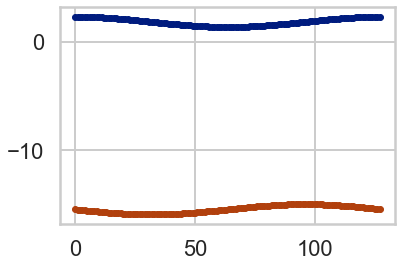

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x[:-1:2],'.')
ax.plot(x[1:-1:2],'.')

Newton法でリミットサイクルを捉える

In [15]:
y = np.copy(x)
a = bdeq2[hbeq2[1]-1]['a']
for m in range(12):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(np.linalg.norm(b))
print(y)

83.39627205855717
1.7751768822618856
1.3369929065021189
0.3483115208107321
0.09531631392339272
0.008491365270787178
7.63802931758492e-05
5.89808082141663e-09
7.213397483126336e-13
7.956177917048393e-13
8.366934913085939e-13
6.961110000650344e-13
[  2.06834557 -15.64772672   2.06652367 -15.70390827   2.0640474
 -15.75889267   2.0609346  -15.81253637   2.05720431 -15.8647027
   2.05287658 -15.91526216   2.04797236 -15.96409267   2.04251331
 -16.01107976   2.0365217  -16.0561167    2.03002031 -16.09910459
   2.02303228 -16.13995242   2.01558103 -16.17857702   2.00769019
 -16.21490311   1.99938351 -16.24886314   1.9906848  -16.28039729
   1.98161786 -16.30945326   1.97220643 -16.33598618   1.96247419
 -16.35995843   1.95244465 -16.38133949   1.9421412  -16.40010568
   1.93158704 -16.41624003   1.92080518 -16.42973202   1.90981843
 -16.44057741   1.89864938 -16.44877795   1.88732042 -16.45434122
   1.8758537  -16.45728037   1.86427117 -16.45761389   1.85259457
 -16.45536541   1.84084544 -16

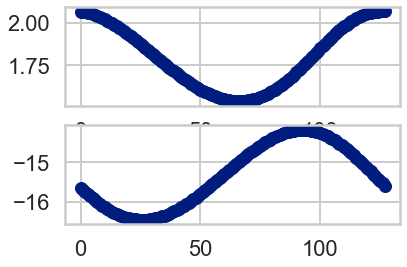

In [16]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax.plot(y[:-1:2],'o-')
ax2.plot(y[1:-1:2],'o-')

Hopf分岐で分岐したリミットサイクルの追跡

In [17]:
x = np.copy(y)
bdc,bpc,lpc=pf.pathfollow(x, a, func, dfdx, dfda, nmax=400, h=0.5, epsr=1.0e-10, epsb=1.0e-10, amax=2.08, problem=None, quiet=True)

# parameter arrived at boundary


In [18]:
bdc[-1]['a']

array([2.08374174])

In [19]:
bdc_r = np.array([pt['a'][0] for pt in bdc])
bdc_T = np.array([pt['x'][-1] for pt in bdc])
bdc_Vmax = np.array([np.max(pt['x'][:-1:2]) for pt in bdc])
bdc_Vmin = np.array([np.min(pt['x'][:-1:2]) for pt in bdc])

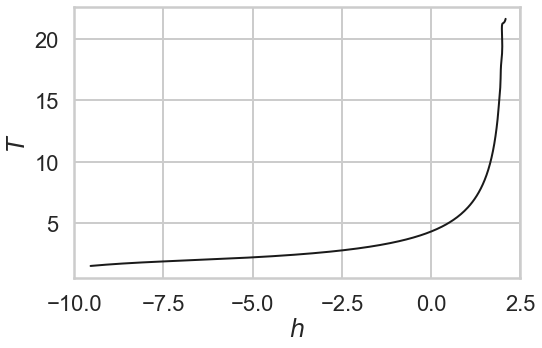

In [20]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-10,2.5)
ax.set_xlabel("$h$")
ax.set_ylabel("$T$")
ax.plot(bdc_r, bdc_T, '-k')
# plt.savefig("bd_HR_T.pdf", bbox_inches='tight')

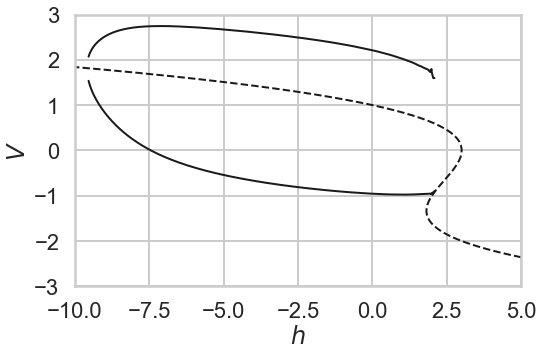

In [21]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-10,5)
ax.set_ylim(-3,3)
ax.set_xlabel("$h$")
ax.set_ylabel("$V$")
ax.plot(bdeq_r, bdeq_V, '--k')
ax.plot(bdeq2_r, bdeq2_V, '--k')
ax.plot(bdc_r, bdc_Vmax, '-k')
ax.plot(bdc_r, bdc_Vmin, '-k')
# plt.savefig("bd_HR_V.pdf", bbox_inches='tight')

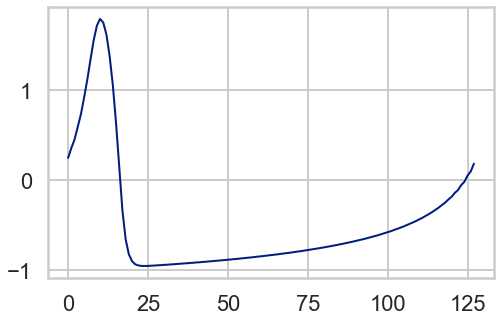

In [22]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(bdc[-40]['x'][:-1:2],'-')

# 多段射撃法

In [23]:
Npts = 8
def func(x, a):
    T = x[-1]
    def f2(t, y):
        return T * f(y, a)
    r = ode(f2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    x1 = np.zeros(len(x))

    for k in range(Npts-1):
        y0 = np.copy(x[k*n:(k+1)*n])
        r.set_initial_value(y0, 0.0)
        y1 = r.integrate(r.t+h)
        x1[k*n:(k+1)*n] = y1 - x[(k+1)*n:(k+2)*n]

    y0 = np.copy(x[-(n+1):-1])
    r.set_initial_value(y0, 0.0)
    y1 = r.integrate(r.t+h)
    x1[-(n+1):-1] = y1 - x[:n]

    x1[-1] = x[:-1:n] @ np.array([np.sin(2*k*h*np.pi) for k in range(Npts)])
    return x1

def dfdx(x, a):
    def df2(t, y, n):
        z = np.zeros((n+1)*(n+2))
        z[:n] = y[n] * f(y[:n], a)
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = y[n] * fx(y[:n], a)
        J[:n, n] = f(y[:n], a)
        for m in range(n+1):
            z[(n+1)*(m+1):(n+1)*(m+2)] = J @ y[(n+1)*(m+1):(n+1)*(m+2)]
        return z
    r = ode(df2).set_integrator('dop853', atol=1.0e-14, rtol=1.0e-14)
    n = (len(x)-1) // Npts
    h = 1.0 / Npts
    A = np.zeros((len(x), len(x)))
    I = np.identity(n+1)

    for k in range(Npts-1):
        y0 = np.zeros((n+1)*(n+2))
        y0[:n] = x[k*n:(k+1)*n]
        y0[n] = x[-1]
        for m in range(n+1):
            y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
        r.set_initial_value(y0, 0.0).set_f_params(n)
        y1 = r.integrate(r.t+h)
        for m in range(n):
            A[k*n:(k+1)*n,k*n+m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
        A[k*n:(k+1)*n, (k+1)*n:(k+2)*n] = -np.identity(n)
        A[k*n:(k+1)*n, -1] = y1[-(n+1):-1]

    y0 = np.zeros((n+1)*(n+2))
    y0[:n] = x[-(n+1):-1]
    y0[n] = x[-1]
    for m in range(n+1):
        y0[(n+1)*(m+1):(n+1)*(m+2)] = I[:,m]
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    for m in range(n):
        A[-(n+1):-1,-(n+1)+m] = y1[(n+1)*(m+1):(n+1)*(m+1)+n]
    A[-(n+1):-1, :n] = -np.identity(n)
    A[-(n+1):-1, -1] = y1[-(n+1):-1]

    for k in range(Npts):
        A[-1,k*n] = np.sin(2*np.pi*k*h)
    return A

def dfda(x, a):
    T = x[-1]
    def df2(t, y, n):
        z = np.zeros(2*(n+1))
        z[:n] = T * f(y[:n], np.array([y[n]]))
        z[n] = 0.0
        J = np.zeros((n+1, n+1))
        J[:n, :n] = fx(y[:n], np.array([y[n]]))
        J[:n, n] = fa(y[:n], np.array([y[n]]))
        z[n+1:] = T * J @ y[n+1:]
        return z
    n = (len(x) - 1) // Npts
    h = 1.0 / Npts
    r = ode(df2).set_integrator('dop853', atol=1e-14, rtol=1e-14)
    b = np.zeros(len(x))

    for k in range(Npts-1):
        y0 = np.zeros(2*(n+1))
        y0[:n] = np.copy(x[k*n:(k+1)*n])
        y0[n] = a[0]
        y0[-1] = 1.0
        r.set_initial_value(y0, 0.0).set_f_params(n)
        y1 = r.integrate(r.t+h)
        b[k*n:(k+1)*n] = y1[n+1:2*n+1]

    y0[:n] = np.copy(x[-(n+1):-1])
    y0[n] = a[0]
    y0[-1] = 1.0
    r.set_initial_value(y0, 0.0).set_f_params(n)
    y1 = r.integrate(r.t+h)
    b[-(n+1):-1] = y1[n+1:2*n+1]

    return b

In [24]:
vr = bdeq2[hbeq2[1]]['vr']
vi = bdeq2[hbeq2[1]]['vi']
vr /= np.sqrt(vr@vr)
vi /= np.sqrt(vi@vi)
rr = np.hypot(vr, vi)
tt = np.array([np.angle(vr[i]+1.j*vi[i]) for i in range(len(vr))])
ev = eigvals(fx(bdeq2[hbeq2[1]-1]['x'], bdeq2[hbeq2[1]-1]['a']))

In [25]:
x = np.zeros(2*Npts+1)
da = np.abs(bdeq2[hbeq2[1]]['a'][0] - bdeq2[hbeq2[1]-1]['a'][0])
for j in range(Npts):
    x[2*j:2*(j+1)] = bdeq2[hbeq2[1]-1]['x'] + 2 * np.sqrt(da) * rr * np.cos(2*np.pi*j/Npts + tt - tt[0])
x[-1] = 2*np.pi/np.imag(ev[0])

In [26]:
y = np.copy(x)
a = bdeq2[hbeq2[1]-1]['a']
for m in range(12):
    b = func(y, a)
    A = dfdx(y, a)
    y -= solve(A, b)
    print(np.linalg.norm(b))
# x = np.copy(y)
print(y)

2.2586504887251064
0.07985898821767388
0.007409036151628275
0.003336334035679782
0.00030515054468293457
2.2452251675668243e-06
1.0171411829740142e-10
8.073390384088094e-15
1.371114198290873e-14
1.1214901273581282e-14
6.3893310952859035e-15
9.5608188662104e-15
[  2.06901919 -15.64803573   1.97260051 -16.33826827   1.79344961
 -16.40899249   1.62167077 -15.89786852   1.53630407 -15.09488909
   1.59522576 -14.39344856   1.79158023 -14.19777262   2.00168924
 -14.71955072   1.53113366]


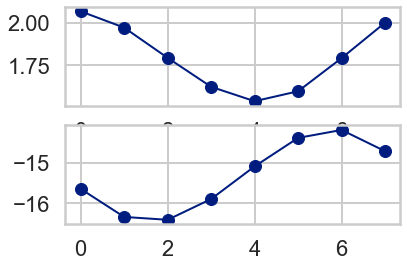

In [27]:
fig = plt.figure()
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax.plot(y[:-1:2],'o-')
ax2.plot(y[1:-1:2],'o-')

In [29]:
x = np.copy(y)
bdc,bpc,lpc=pf.pathfollow(x, a, func, dfdx, dfda, nmax=400, h=0.5, epsr=1.0e-10, epsb=1.0e-10, amax=2.08, problem=None, quiet=True)

# parameter arrived at boundary


In [30]:
bdc[-1]['a']

array([2.080317])

In [31]:
bdc_r = np.array([pt['a'][0] for pt in bdc])
bdc_T = np.array([pt['x'][-1] for pt in bdc])

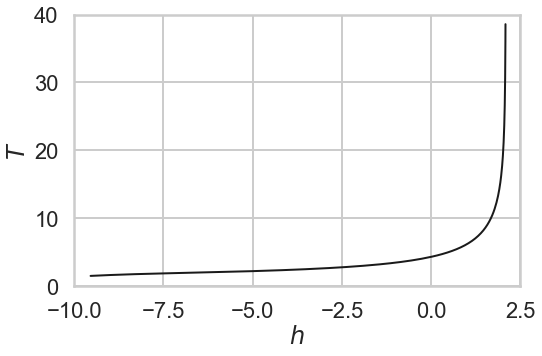

In [32]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-10,2.5)
ax.set_ylim(0,40)
ax.set_xlabel("$h$")
ax.set_ylabel("$T$")
ax.plot(bdc_r, bdc_T, '-k')
# plt.savefig("bd_HR_T.pdf", bbox_inches='tight')

In [33]:
N = 256
Vmax, Vmin = [], []
for pt in bdc:
    x0, a0, T = pt['x'][0:2], pt['a'][0], pt['x'][-1]
    dt = T / N
    r = ode(HR).set_integrator('dop853')
    r.set_initial_value(x0, 0.0).set_f_params(1.0, 3.0, 1.0, 5.0, 2.0, a0)
    V0, V1 = x0[0], x0[0]
    while r.successful and r.t < T:
        y0 = r.integrate(r.t+dt)
        V0 = y0[0] if y0[0] > V0 else V0
        V1 = y0[0] if y0[0] < V1 else V1
    Vmax.append(V0)
    Vmin.append(V1)
bdc_Vmax = np.array(Vmax)
bdc_Vmin = np.array(Vmin)

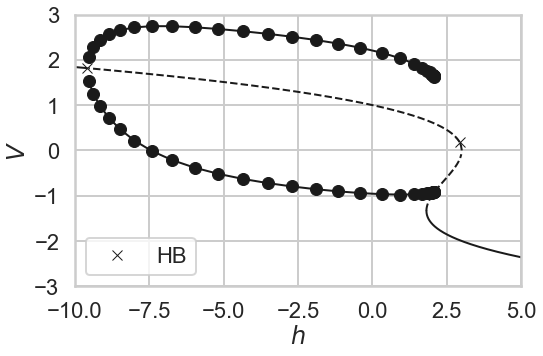

In [34]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.set_xlim(-10,5)
ax.set_ylim(-3,3)
ax.set_xlabel("$h$")
ax.set_ylabel("$V$")
ax.plot(bdeq_r, bdeq_V, '-k')
ax.plot(bdeq2_r[:lpeq2[0]], bdeq2_V[:lpeq2[0]], '-k')
ax.plot(bdeq2_r[lpeq2[0]:lpeq2[1]], bdeq2_V[lpeq2[0]:lpeq2[1]], '--k')
ax.plot(bdeq2_r[lpeq2[1]:hbeq2[0]], bdeq2_V[lpeq2[1]:hbeq2[0]], '--k')
ax.plot(bdeq2_r[hbeq2[0]:hbeq2[1]], bdeq2_V[hbeq2[0]:hbeq2[1]], '--k')
ax.plot(bdeq2_r[hbeq2[1]:], bdeq2_V[hbeq2[1]:], '-k')
ax.plot(bdeq2_r[hbeq2[0]], bdeq2_V[hbeq2[0]], 'xk', markersize=10,label='HB')
ax.plot(bdeq2_r[hbeq2[1]], bdeq2_V[hbeq2[1]], 'xk', markersize=10)
ax.plot(bdc_r[::5], bdc_Vmax[::5], 'o-k')
ax.plot(bdc_r[::5], bdc_Vmin[::5], 'o-k')
ax.legend()
# plt.savefig("bd_HR_V.pdf", bbox_inches='tight')

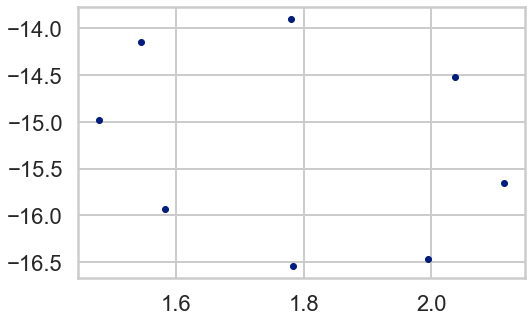

In [35]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(bdc[1]['x'][:-1:2], bdc[1]['x'][1:-1:2], '.')